In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sms-spam-collection-dataset/spam.csv


In [2]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

keras = tf.keras

TensorFlow version: 2.16.1


In [3]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

hyperparams = {
    'vocab_size' : 1000,
    'dim' : 30,
    'max_len' : 515
}

In [4]:
import re
import nltk
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('wordnet')
# ! unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/



[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
data = pd.read_csv('/kaggle/input/sms-spam-collection-dataset/spam.csv', encoding='latin1')
data = data.loc[:, ['v1', 'v2']]
data = data.rename(columns={'v1': 'label', 'v2': 'message'})

<Axes: xlabel='label', ylabel='count'>

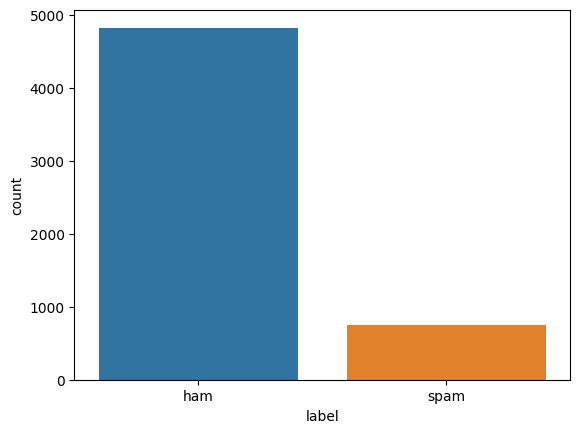

In [6]:
import seaborn as sns
sns.countplot(x=data['label'])

### Prepare Y

In [7]:
y = data['label']
le = LabelEncoder()
Y = le.fit_transform(y)

### Clean X

In [8]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def clean_message(message, method):
    
    def semmatize_msg():
        return [stemmer.stem(word) for word in tokens]
    
    def lemmatize_msg():
        return [lemmatizer.lemmatize(word) for word in tokens]
    
    def lemmatize_pos_msg():
        pos_tags = nltk.pos_tag(tokens)
        return [
            lemmatizer.lemmatize(word, pos='v' if tag.startswith('V') else 'n' if tag.startswith('N') else 'a' if tag.startswith('J') else 'r' if tag.startswith('R') else 'n')
            for word, tag in pos_tags
        ]
    
    # Lowercase the message
    message = message.lower()
    
    # Remove everything except letters
    message = re.sub(r'[^a-z\s]', '', message)
    
    # Tokenize the message
    tokens = nltk.word_tokenize(message)
    
    # Remove single character words and stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if len(word) > 1 and word not in stop_words]
    
    # Apply the selected method for word processing
    if method == 'stem':
        processed_tokens = semmatize_msg()
    elif method == 'lemmatize':
        processed_tokens = lemmatize_msg()
    elif method == 'lemmatize_pos':
        processed_tokens = lemmatize_pos_msg()
    else:
        raise ValueError("Invalid method. Choose from 'stem', 'lemmatize', or 'lemmatize_pos'.")
    
    # Join the tokens back into a single string
    cleaned_message = ' '.join(processed_tokens)

    return cleaned_message

In [9]:
X = data['message'].apply(lambda x: clean_message(x, method='stem'))

### Split dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1234)

### Preproces X

In [11]:
tokenizer = Tokenizer(num_words = hyperparams['vocab_size'])
tokenizer.fit_on_texts(X_train)

def prepare_input(inputx):
    seq_docs = tokenizer.texts_to_sequences(inputx)
    padded_docs = pad_sequences(seq_docs, padding='pre', maxlen=hyperparams['max_len'])
    return padded_docs

X_train = prepare_input(X_train)

### Build Model

In [12]:
def build_model():
    model = tf.keras.models.Sequential([
            keras.layers.Embedding(hyperparams['vocab_size'], hyperparams['dim'], input_shape=(hyperparams['max_len'], )),
            keras.layers.LSTM(256),
            keras.layers.Dense(1, activation='sigmoid')
        ])

    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=['accuracy'])
    print(model.summary())
    return model


model = build_model()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 515, 30)        │        30,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 256)            │       293,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 324,145 (1.24 MB)

 Trainable params: 324,145 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

None


### Train Model

In [13]:
model.fit(X_train, y_train, batch_size=128, epochs=10, validation_split=0.3)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.8530 - loss: 0.1619 - val_accuracy: 0.8726 - val_loss: 0.0900
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.8924 - loss: 0.0807 - val_accuracy: 0.9462 - val_loss: 0.0499
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9709 - loss: 0.0318 - val_accuracy: 0.9650 - val_loss: 0.0289
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9674 - loss: 0.0290 - val_accuracy: 0.9718 - val_loss: 0.0236
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9802 - loss: 0.0180 - val_accuracy: 0.9744 - val_loss: 0.0215
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9860 - loss: 0.0121 - val_accuracy: 0.9744 - val_loss: 0.0198
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.9873 - loss: 0.0118 - val_accuracy: 0.9744 - val_loss: 0.0194
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.9892 - loss: 0.0102 - val_accuracy: 0.9718 - val_loss:

### Evaluate Model

In [14]:
X_test = prepare_input(X_test)
acc = model.evaluate(X_test, y_test)
acc

53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 331ms/step - accuracy: 0.9803 - loss: 0.0172


[0.01844990812242031, 0.9778708219528198]